In [14]:
from DataProcessing import Data
import tensorflow as tf
from tensorflow import keras as keras

# 1. Get Data

## 1.1. Get data from folder

In [15]:
d = Data()
d.get_index_names()
chosen_index = 'GOOGL'
d.preprocess(chosen_index)
df = d.get_data(chosen_index)
df= df.drop(['Date', 'Volume'],axis=1)
df.columns

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']
Processing GOOGL.csv
Saved GOOGL data at data/processed/GOOGL.csv


Index(['High', 'Low', 'Close', 'RSI', 'MFI', 'EMA', 'SO', 'MACD',
       'Next Day Price'],
      dtype='object')

In [16]:
INPUT_SHAPE=8
X = df[df.columns[0:INPUT_SHAPE]].values
Y = df[df.columns[INPUT_SHAPE]].values

TRAIN_PERCENT = 0.7
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

## 1.2. Scale data

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Train model

In [18]:
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.LSTM(100,input_shape=(None,8),return_sequences=True,activation='relu'))
rnn_model.add(keras.layers.Dense(1))
rnn_model.summary()

f:\bk_ky6\ML\project\stock-market-prediction\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, None, 100)      │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 1)        │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,701 (170.71 KB)

 Trainable params: 43,701 (170.71 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [20]:
num_epochs = 200
batch_size = 1
learning_rate = 0.001
Adam = keras.optimizers.Adam(learning_rate)
MSE = keras.losses.MeanSquaredError()

## 2.1. Train

In [21]:
rnn_model.compile(optimizer=Adam,loss=MSE)
history = rnn_model.fit(X_train,Y_train,epochs=num_epochs,validation_data=(X_test,Y_test),batch_size=batch_size)

Epoch 1/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 6698.6104 - val_loss: 253.1800
Epoch 2/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 209.8399 - val_loss: 148.4337
Epoch 3/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 144.2909 - val_loss: 70.8961
Epoch 4/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 61.2318 - val_loss: 25.4545
Epoch 5/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 27.0789 - val_loss: 11.1160
Epoch 6/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 15.2002 - val_loss: 7.6758
Epoch 7/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.7098 - val_loss: 7.2722
Epoch 8/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.3337 - val_loss: 7.4352
Epoch 9/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.0840 - val_loss: 6.7434
Epoch 10/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6.5285 - val_loss: 8.9233
Epoch 11/200
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.2317 - val_loss: 6.8889
Epoch 12/200
871/871 ━━━

## 2.2. Test

In [22]:
Y_pred = rnn_model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [23]:
Y_pred.shape

(374, 1, 1)

In [24]:
Y_pred = Y_pred.reshape(374)

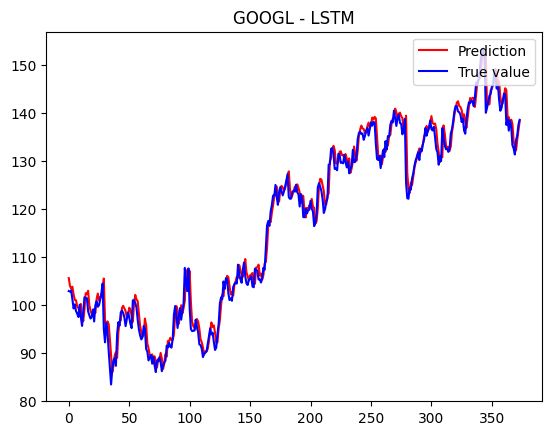

In [25]:
import matplotlib.pyplot as plt
plt.plot(Y_pred,c='red',label = 'Prediction')
plt.plot(Y_test,c='blue',label = 'True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - LSTM')
plt.show()

## 2.3. Evaluate

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 5.931614891562595
Mean Absolute Error: 1.8083793313745502
R-squared: 0.9833731298942733


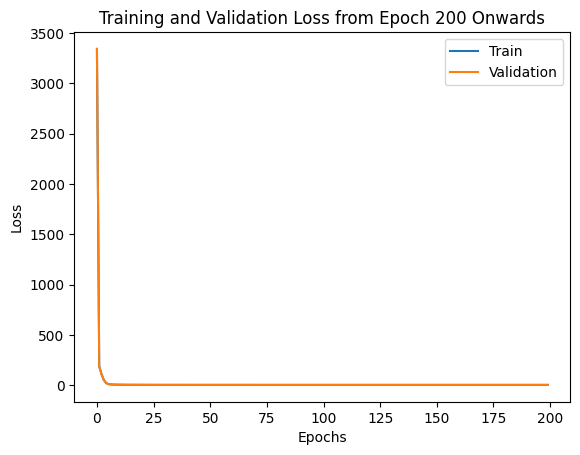

In [27]:
# Plot convergence
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss from Epoch 200 Onwards')
plt.legend()
plt.show()
